## Import Modules

In [37]:
#Here necessary modules and inception V3 is used.
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

base_model = InceptionV3(weights='imagenet')
inception_model = Model(inputs=base_model.input, outputs=base_model.layers[-2].output)



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [42]:
%cd /content/drive/MyDrive/NLP2/flickr//
#WORKING_DIR = '/content/drive/MyDrive/NLP2/flickr'
BASE_DIR = '/content/drive/MyDrive/NLP2/flickr'

/content/drive/MyDrive/NLP2/flickr


## Extract Image Features

In [8]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

base_model = InceptionV3(weights='imagenet')

inception_model = Model(inputs=base_model.input, outputs=base_model.layers[-2].output)

print(inception_model.summary())


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d_282 (Conv2D)         (None, 149, 149, 32)         864       ['input_4[0][0]']             
                                                                                                  
 batch_normalization_282 (B  (None, 149, 149, 32)         96        ['conv2d_282[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_282 (Activation  (None, 149, 149, 32)         0         ['batch_normalization_28

In [10]:
from tensorflow.keras.applications.inception_v3 import preprocess_input

# Here the code will extract features from all images stored in BASE_DIR and convert them into 299*299 input shape to match according to the inception model.
# Later the features will be extracted and mapped according to the keys i.e. filename of respective image.
features = {}
directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
    img_path = os.path.join(directory, img_name)
    image = load_img(img_path, target_size=(299, 299))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    feature = inception_model.predict(image, verbose=0)
    image_id = img_name.split('.')[0]
    features[image_id] = feature


  0%|          | 0/8123 [00:00<?, ?it/s]

In [13]:
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [15]:
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

## Load the Captions Data

In [14]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [16]:
# create mapping of image to captions
mapping = {}
for line in tqdm(captions_doc.split('\n')):
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    image_id = image_id.split('.')[0]
    caption = " ".join(caption)
    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [17]:
len(mapping)

8091

## Preprocess Text Data

In [18]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
            caption = caption.lower()
            caption = caption.replace('[^A-Za-z]', '')
            caption = caption.replace('\s+', ' ')
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [19]:
# Mapping before preprocess of text
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [20]:
clean(mapping)

In [ ]:
# Mapping after preprocess of text
mapping['1000268201_693b08cb0e']

In [22]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [23]:
len(all_captions)

40455

In [24]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [25]:
# Tokenizing the text for captions
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [28]:
vocab_size

8485

In [27]:
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

## Train Test Split

In [29]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [30]:
# This function is used to generate data for image captions
# It travels through all images and their respective captions, and predicts next
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

## Model Creation

87910968/87910968 [==============================] - 3s 0us/step


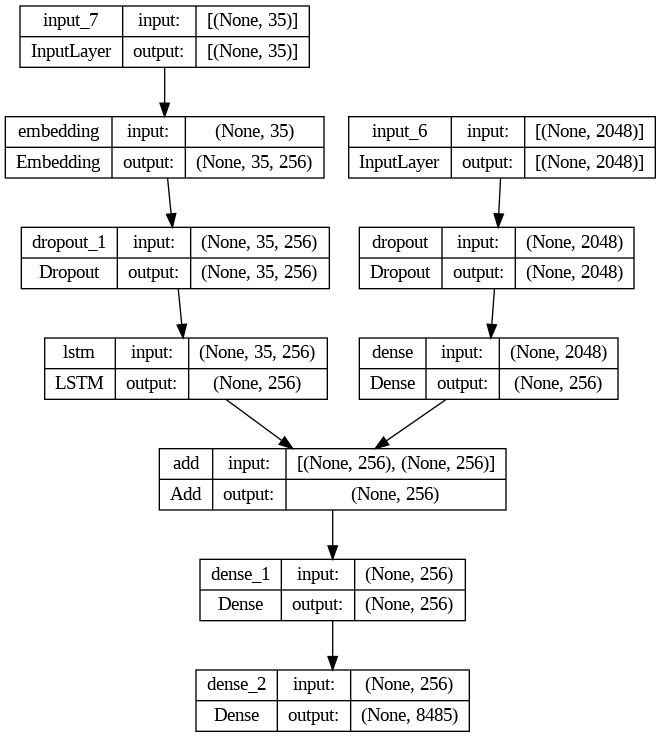

In [31]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

inputs1 = Input(shape=(2048,))  # Output shape of InceptionV3 without classification layers
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

plot_model(model, show_shapes=True)


In [32]:

epochs = 20
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

227/227 [==============================] - 64s 281ms/step - loss: 2.2748


In [33]:
model.save(WORKING_DIR+'/best_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Generate Captions for the Image

In [34]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [35]:
# the captions will have startseq and endseq at the end of captions
def predict_caption(model, image, tokenizer, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)
        yhat = model.predict([image, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idx_to_word(yhat, tokenizer)

        if word is None:
            break

        in_text += " " + word
        if word == 'endseq':
            break

    return in_text

In [36]:
from nltk.translate.bleu_score import corpus_bleu
actual, predicted = list(), list()

for key in tqdm(test):
    captions = mapping[key]
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    actual.append(actual_captions)
    predicted.append(y_pred)

# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.561140
BLEU-2: 0.337470


## Visualize the Results

---------------------Actual---------------------
startseq black dog and spotted dog are fighting endseq
startseq black dog and tri-colored dog playing with each other on the road endseq
startseq black dog and white dog with brown spots are staring at each other in the street endseq
startseq two dogs of different breeds looking at each other on the road endseq
startseq two dogs on pavement moving toward each other endseq
--------------------Predicted--------------------
startseq black and white dog is playing with toy endseq


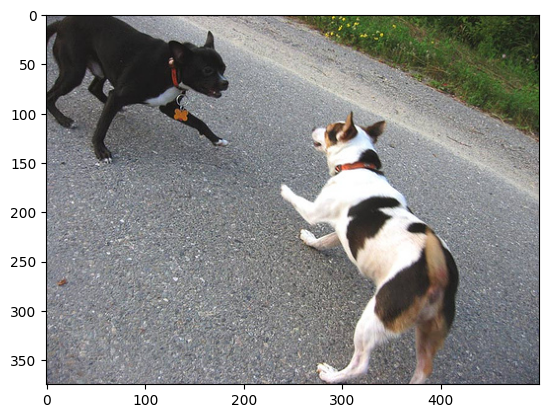

In [45]:
import os
from PIL import Image
import matplotlib.pyplot as plt

WORKING_DIR = '/content/drive/MyDrive/NLP2/flickr'

def generate_caption(image_name):
    image_id = image_name.split('.')[0]
    img_path = os.path.join(WORKING_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)
    plt.show()

generate_caption("1001773457_577c3a7d70.jpg")


## Test with Real Image

In [46]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model

inception_model = InceptionV3(weights='imagenet')

inception_model = Model(inputs=inception_model.inputs, outputs=inception_model.layers[-2].output)


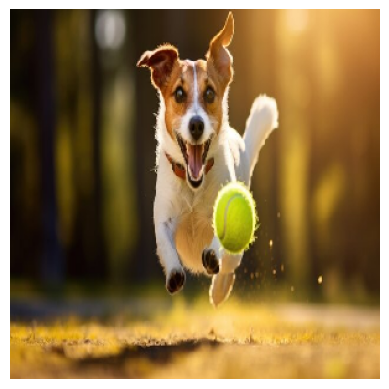

Predicted Caption: startseq dog with tennis ball in its mouth is playing with tennis ball in its mouth endseq


In [53]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.inception_v3 import preprocess_input
import matplotlib.pyplot as plt

image_path = '/content/drive/MyDrive/NLP2/5.jpg'

image = load_img(image_path, target_size=(299, 299))
image_np = img_to_array(image)
image_np = image_np.reshape((1, image_np.shape[0], image_np.shape[1], image_np.shape[2]))
image_np = preprocess_input(image_np)

feature = inception_model.predict(image_np, verbose=0)

predicted_caption = predict_caption(model, feature, tokenizer, max_length)

plt.imshow(image)
plt.axis('off')
plt.show()

print("Predicted Caption:", predicted_caption)


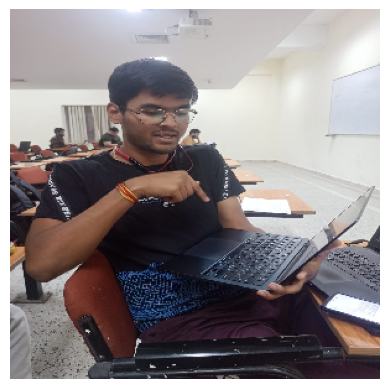

Predicted Caption: startseq man in black jacket and glasses is sitting at table reading endseq


In [58]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.inception_v3 import preprocess_input
import matplotlib.pyplot as plt

image_path = '/content/drive/MyDrive/NLP2/7.jpeg'

image = load_img(image_path, target_size=(299, 299))
image_np = img_to_array(image)
image_np = image_np.reshape((1, image_np.shape[0], image_np.shape[1], image_np.shape[2]))
image_np = preprocess_input(image_np)

feature = inception_model.predict(image_np, verbose=0)

predicted_caption = predict_caption(model, feature, tokenizer, max_length)

plt.imshow(image)
plt.axis('off')
plt.show()

print("Predicted Caption:", predicted_caption)
